In [4]:
%tensorflow_version 2.x  # this line is not required unless you are in google colab
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in google colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [5]:
# MNIST Fashion Dataset.
# 60,000 images for testing, 10,000 images for validation/testing

fashion_mnist = keras.datasets.fashion_mnist  # load dataset

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()  # split into tetsing and training

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
train_images.shape # 60,000 images, each 28x28 (784 pixels)

(60000, 28, 28)

In [ ]:
train_images[0,23,23] # value of one pixel (grayscale image)

194

In [4]:
# Labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

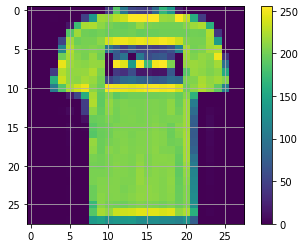

In [5]:
plt.figure()
plt.imshow(train_images[1])
plt.colorbar()
plt.grid(True)
plt.show()

In [6]:
# Data pre-processing
train_images = train_images / 255.0 # Change range from 0-255 to 0-1

test_images = test_images / 255.0

In [7]:
#VECTORIZED VERSION
@np.vectorize
def sigmoid(z):
    if z >= 0:
      return 1.0 / (1.0 + np.e**(-z))
    else:
      return np.e**(z) / (1 + np.e**(z))

@np.vectorize
def sigmoidPrime(z):
    # Derivative of Sigmoid Function
      return sigmoid(z) * (1-sigmoid(z))

class Model3:
    def __init__(self, model_structure=[2, 3, 2], modelActivationFunctions=["sigmoid", "sigmoid"], sig=None, sigPrime=None):
        self.model_structure = model_structure
        self.modelActivationFunctions = modelActivationFunctions
        self.modelWidth = len(model_structure)

        self.sigmoid = sig
        self.sigmoidPrime = sigPrime

        # Safety Check to make sure model structure is legitimate
        if self.modelWidth<3 or self.modelWidth-1!=len(self.modelActivationFunctions):
            print("Model Structure Error!")
            exit(1)  

        # Weights (Parameters) - Randomly Assigned
        self.weights = list()
        self.weights.append(np.random.randn(self.model_structure[1],self.model_structure[0])) # Input Layer Weights
        for i in range(1, self.modelWidth-1):
            self.weights.append(np.random.randn(self.model_structure[i+1], self.model_structure[i]))

        # Biases - Randomly Assigned
        self.biases = list()
        for i in range(1, self.modelWidth):
            self.biases.append(np.random.randn(self.model_structure[i], 1))  # Length should be number of columns of X
        '''self.weights = [np.array(([[0.15, 0.3], [0.2, 0.35], [0.25, 0.4]]), dtype=float), np.array(([[0.5, 0.6, 0.7], [0.55, 0.65, 0.75]]), dtype=float)]
        self.biases = [[[0.45], [0.45], [0.45]], [[0.8], [0.8]]]'''
    
    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)
    '''
    def softmax(z):
        z -= np.max(z)
        sm = (np.exp(z).T / np.sum(np.exp(z), axis=0)).T
        return sm
    '''
    def softmaxPrime(self, z):
        z -= np.max(z)
        sm = (np.exp(z).T / np.sum(np.exp(z), axis=0)).T
        s = sm.reshape(-1,1)# Reshape the 1-d softmax to 2-d so that np.dot will do the matrix multiplication
        return np.diagflat(s) - np.dot(s, s.T)

    def relu(self, z):
        return np.maximum(0, z)
    
    def reluPrime(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x
    
    def applyActivationFunction(self, values, activation):
        if activation=='sigmoid':
            return self.sigmoid(values)
        elif activation=='softmax':
            return self.softmax(values)
        elif activation=='relu':
            return self.relu(values)
        else:
            print("Unknown Activation Function! Got:", activation)
            exit(1)
    
    def applyActivationFunctionPrime(self, values, activation):
        if activation=='sigmoid':
            return self.sigmoidPrime(values)
        elif activation=='softmax':
            return self.softmaxPrime(values)
        elif activation=='relu':
            return self.reluPrime(values)
        else:
            print("Unknown Activation Function! Got:", activation)
            exit(1)

    def forward(self, X):
        # Propogate inputs through networks
        self.aValues = list()
        self.zValues = list()
        self.aValues.append(X) # First a value = input values
        for i in range(0, len(self.weights)):
            self.zValues.append(np.dot(self.weights[i], self.aValues[i]) + self.biases[i])
            self.aValues.append(self.applyActivationFunction(self.zValues[i], self.modelActivationFunctions[i]))
        yHat = self.aValues[-1]
        return yHat

    def costFunction(self, X, y):
        # Compute cost using the weights already stored
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
    
    def costFunctionPrime(self, X, y):
        # Computes partial derivatives of Cost function with respect to weights & biases
        self.yHat = self.forward(X)
        
        weightDerivatives = list() # Derivative of Cost function with respect to weights
        biasDerivatives = list() # Derivative of Cost function with respect to biases

        # Last Layer derivatives
        delta = np.multiply(-(y-self.aValues[-1]), self.sigmoidPrime(self.zValues[-1]))
        weightDerivatives.insert(0, np.dot(delta, self.aValues[-2].T))
        biasDerivatives.insert(0, delta.sum(axis=1).reshape(delta.shape[0],1)) 
        
        # Derivatives for the other layers (L-1, L-2, ...)
        for i in range(self.modelWidth-2, 0, -1):
            delta = np.multiply(np.dot(self.weights[i].T, delta), self.applyActivationFunctionPrime(self.zValues[i-1], self.modelActivationFunctions[i])) 
            weightDerivatives.insert(0, np.dot(delta, self.aValues[i-1].T))
            biasDerivatives.insert(0, delta.sum(axis=1).reshape(delta.shape[0],1))

        return weightDerivatives, biasDerivatives
    
    def tuneParams(self, X, y, learning_rate=0.5, getLoss=False):
        # Get Derivatives of Weights & Biases, and then adjust weights/biases with learning rate*derivatives
        # getLoss: if you want to calculate loss (before adjusting weights)
        self.weightDerivatives, self.biasDerivatives = self.costFunctionPrime(X, y)
        
        loss = None
        if getLoss:
           loss = ((y-self.yHat)**2)/2
           # print(X.shape)
           loss = loss.sum()/X.shape[1]

        scalar = learning_rate # learning rate divided by number of samples
        for i in range(0, len(self.weights)):
            self.weights[i] = self.weights[i] - (scalar*self.weightDerivatives[i] / X.shape[1])
            self.biases[i] = self.biases[i] - (scalar*self.biasDerivatives[i] / X.shape[1])
        
        return loss
    
    def one_hot_encoder(self, expected):
        # formats label into array of zeros except for the index of the correct prediction
        #expected = expected.to_numpy()
        expected = expected.reshape(expected.shape[0],)
        b = np.zeros((expected.size, int(expected.max()+1)))
        b[np.arange(expected.size), expected] = 1
        return b.T

    def fit(self, X, y, TestDataX=None, TestDatay=None, learning_rate=0.5, epochs=10, batch_size=32, flatten=False, stagger=True):
        # X: Training Data
        # y: Labels for Training Data
        # TestingDataX: Testing Data (if staggering)
        # TestingDatay: Labels for Testing Data (if staggering)
        # learning_rate: rate at which to update the weights with their derivatives
        # epochs: number of "runs" to execute. Each run is going through the entire dataset once
        # batch_size: number of samples to go through before tuning parameters
        # Flatten: if each sample of the test data needs to be flatten (like if each sample is an image)
        # Stagger: if to test model after every epoch

        if X.shape[0] % batch_size != 0:
          print("# of training samples isn't divisible by entered batch size!")
          exit(1)
        
        if stagger and ((TestDataX is None) or (TestDatay is None)):
          print("You can't stagger when you don't pass in testing data and/or it's labels!")
          exit(1)

        if flatten:
          inputNumber = 1
          #print(X.shape)
          for i in range(1, len(X.shape)):
            inputNumber*=X.shape[i]
          X = X.reshape(X.shape[0], inputNumber)
          #print(X.shape)
          TestDataX = TestDataX.reshape(TestDataX.shape[0], inputNumber)
        
        y_formatted = self.one_hot_encoder(train_labels)
        loss_list_average = list() # Keeps all the average losses from each epoch
        train_accuracies = list() # Keeps all the training accuracies from each epoch (which is apparently: (1-averageLoss))
        test_accuracies = list() # Keeps all the testing accuracies from each epoch
        for i in range(1, epochs+1):
          print("Epoch:", i)
          loss_list = list() # This is for keeping all the losses from each batch in the epoch; used to calculate lost_list_average
          for j in range(1, int(X.shape[0]/batch_size)+1): # Going through each batch
            if j%int((int(X.shape[0]/batch_size)/10)) == 0:
              print("Iteration:", j)
            # Slice appropriate batch sizes
            X_batch = X[(j-1)*batch_size : j*batch_size].T #'''Why do we need to transpose here???'''
            # print(y_formatted.shape)
            y_batch_formatted = y_formatted[:, (j-1)*batch_size : j*batch_size]
            # print(y_batch_formatted.shape)
            # Training & Getting Loss
            loss = self.tuneParams(X_batch, y_batch_formatted, learning_rate, getLoss=True)
            # print("Loss:", loss)
            loss_list.append(loss)
          # print(model.weights)
          loss_list_average.append((sum(loss_list)/len(loss_list)))
          train_accuracies.append(1 - loss_list_average[i-1])
          print("Average loss across batches:", loss_list_average[i-1])
          print("Training Accuracy:", train_accuracies[i-1])

          if stagger:
            outputs = self.forward(TestDataX.T)
            # print(outputs.shape)
            predictions = list()
            outputs = outputs.T
            for output in outputs: # Going through output for each sample to format prediction
              #print(output)
              predictions.append(np.argmax(output))
            numberOfCorrect = 0
            # print(len(predictions))
            # print(TestDatay.shape)
            for j in range(0, len(TestDatay)): # Calculating the accruacy
              # print(str(j)+"|", "Prediction:", predictions[j], "Actual:", TestDatay[j])
              if TestDatay[j] == predictions[j]:
                numberOfCorrect+=1
            print("Number of Correct:", numberOfCorrect)
            print("Total Number:", len(TestDatay))
            testAccuracy = numberOfCorrect/len(TestDatay)
            print("Testing Accuracy:", testAccuracy)
            test_accuracies.append(testAccuracy)
          print()
          
          # Shuffling
          # print(X.shape)
          # print(y_formatted.shape)
          X_shuffled, y_formatted_shuffled = shuffle(X, y_formatted.T, random_state=0)
          X = X_shuffled
          y_formatted = y_formatted_shuffled.T

        return loss_list_average, train_accuracies, test_accuracies
        

In [8]:
model = Model3(model_structure=[784, 128, 10], modelActivationFunctions=['relu', 'sigmoid'], sig=sigmoid, sigPrime=sigmoidPrime)

In [9]:
# Training the model

(train_images, train_labels), (test_images, test_labels)

model.fit(train_images, train_labels, test_images, test_labels, learning_rate=0.01, epochs=10, batch_size=32, flatten=True, stagger=True)

Epoch: 1
Iteration: 187
Iteration: 374
Iteration: 561
Iteration: 748
Iteration: 935
Iteration: 1122
Iteration: 1309
Iteration: 1496
Iteration: 1683
Iteration: 1870
Average loss across batches: 1.739031203484398
Training Accuracy: -0.739031203484398
Number of Correct: 1002
Total Number: 10000
Testing Accuracy: 0.1002

Epoch: 2
Iteration: 187
Iteration: 374
Iteration: 561
Iteration: 748
Iteration: 935
Iteration: 1122
Iteration: 1309
Iteration: 1496
Iteration: 1683
Iteration: 1870
Average loss across batches: 0.9872659671793507
Training Accuracy: 0.012734032820649333
Number of Correct: 1004
Total Number: 10000
Testing Accuracy: 0.1004

Epoch: 3
Iteration: 187
Iteration: 374
Iteration: 561
Iteration: 748
Iteration: 935
Iteration: 1122
Iteration: 1309
Iteration: 1496
Iteration: 1683
Iteration: 1870
Average loss across batches: 0.9201508176145284
Training Accuracy: 0.07984918238547156
Number of Correct: 1004
Total Number: 10000
Testing Accuracy: 0.1004

Epoch: 4
Iteration: 187
Iteration: 374

([1.739031203484398,
  0.9872659671793507,
  0.9201508176145284,
  0.9107811150603118,
  0.9066966497816988,
  0.9041864150277211,
  0.9023380474161983,
  0.9009774655876592,
  0.8997818015790944,
  0.8986883923128152],
 [-0.739031203484398,
  0.012734032820649333,
  0.07984918238547156,
  0.08921888493968821,
  0.09330335021830116,
  0.09581358497227888,
  0.09766195258380173,
  0.09902253441234077,
  0.10021819842090562,
  0.10131160768718483],
 [0.1002,
  0.1004,
  0.1004,
  0.1005,
  0.1007,
  0.1007,
  0.101,
  0.1011,
  0.1014,
  0.1014])

In [8]:
model = Model3(model_structure=[784, 128, 10], modelActivationFunctions=['relu', 'sigmoid']) # Another test

In [9]:
# Training the model

(train_images, train_labels), (test_images, test_labels)

model.fit(train_images, train_labels, test_images, test_labels, learning_rate=0.01, epochs=10, batch_size=32, flatten=True, stagger=True)

Epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in square


Average loss across batches: 1.127746841487802
Training Accuracy: -0.12774684148780202
Number of Correct: 1577
Total Number: 10000
Testing Accuracy: 0.1577

Epoch: 2
Average loss across batches: 0.5479248235545682
Training Accuracy: 0.4520751764454318
Number of Correct: 1799
Total Number: 10000
Testing Accuracy: 0.1799

Epoch: 3
Average loss across batches: 0.5199435405142032
Training Accuracy: 0.4800564594857968
Number of Correct: 1878
Total Number: 10000
Testing Accuracy: 0.1878

Epoch: 4
Average loss across batches: 0.5110870566022259
Training Accuracy: 0.48891294339777414
Number of Correct: 1943
Total Number: 10000
Testing Accuracy: 0.1943

Epoch: 5
Average loss across batches: 0.5059015155535658
Training Accuracy: 0.4940984844464342
Number of Correct: 1979
Total Number: 10000
Testing Accuracy: 0.1979

Epoch: 6
Average loss across batches: 0.502763514000012
Training Accuracy: 0.49723648599998804
Number of Correct: 2002
Total Number: 10000
Testing Accuracy: 0.2002

Epoch: 7
Average 

([1.127746841487802,
  0.5479248235545682,
  0.5199435405142032,
  0.5110870566022259,
  0.5059015155535658,
  0.502763514000012,
  0.5000992457414055,
  0.4974872605834454,
  0.4948856337601316,
  0.49213885363745],
 [-0.12774684148780202,
  0.4520751764454318,
  0.4800564594857968,
  0.48891294339777414,
  0.4940984844464342,
  0.49723648599998804,
  0.4999007542585945,
  0.5025127394165546,
  0.5051143662398684,
  0.50786114636255],
 [0.1577,
  0.1799,
  0.1878,
  0.1943,
  0.1979,
  0.2002,
  0.2031,
  0.2028,
  0.2042,
  0.2053])